In [1]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/
#
# This notebook can be run in Google Colab at https://colab.research.google.com
# by either downloading this ipynb and uploading it, or by looking up the
# notebook directly on GitHub in Colab's "Open notebook" dialog.

In [3]:
# Install required packages.
# !pip install soundfile
# !git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!dir

[WinError 3] The system cannot find the path specified: 'models/research/audioset/yamnet'
d:\Github\YAMNET\models\research\audioset\yamnet


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 34 14.5M   34 5214k    0     0  7264k      0  0:00:02 --:--:--  0:00:02 7262k
100 14.5M  100 14.5M    0     0  11.2M      0  0:00:01  0:00:01 --:--:-- 11.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2  153k    2  3330    0     0   9482      0  0:00:16 --:--:--  0:00:16  9487
100  153k  100  153k    0     0   399k      0 --:--:-- --:--:-- --:--:--  399k


 Volume in drive D is Data
 Volume Serial Number is 4A86-28C0

 Directory of d:\Github\YAMNET\models\research\audioset\yamnet

04/04/2022  11:00 pm    <DIR>          .
04/04/2022  10:18 pm    <DIR>          ..
04/04/2022  10:18 pm             7,919 export.py
04/04/2022  10:18 pm             7,655 features.py
04/04/2022  10:18 pm             2,371 inference.py
04/04/2022  10:18 pm             1,898 params.py
04/04/2022  10:18 pm             5,146 README.md
04/04/2022  11:00 pm           157,484 speech_whistling2.wav
04/04/2022  11:00 pm        15,296,092 yamnet.h5
04/04/2022  10:18 pm             5,687 yamnet.py
04/04/2022  10:18 pm            14,096 yamnet_class_map.csv
04/04/2022  10:18 pm             2,634 yamnet_test.py
04/04/2022  11:00 pm           137,888 yamnet_visualization.ipynb
              11 File(s)     15,638,870 bytes
               2 Dir(s)  101,779,988,480 bytes free


In [4]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

In [5]:
# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0

In [6]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [11]:
import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

# Set up the YAMNet model.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')
yamnet.summary()

Model: "yamnet_frames"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.compat.v1.shape_1 (TFOpLamb  (1,)                0           ['input_2[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_1 (Sl  ()                  0           ['tf.compat.v1.shape_1[0][0]']   
 icingOpLambda)                                                                                   
                                                                                      

In [8]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

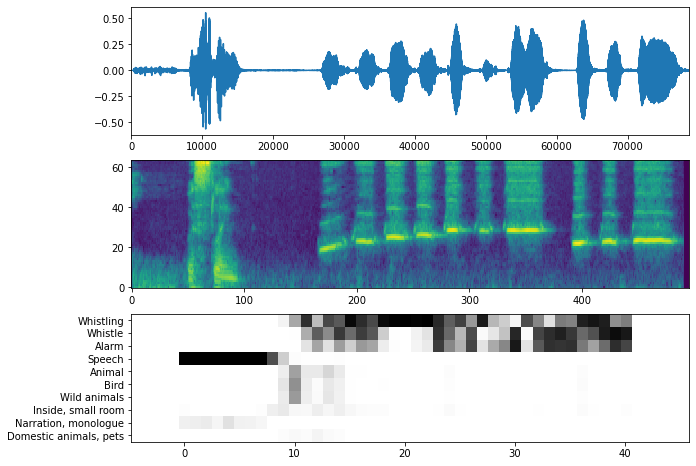

In [10]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))
